In [1]:
#Data Wrangling
import numpy as np
import pandas as pd

#Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

#Training & Testing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df_store = pd.read_csv('stores.csv')
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [3]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
df_features = pd.read_csv('features.csv')
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [6]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) 

In [7]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [8]:
df.shape

(421570, 16)

In [9]:
#Checking missing values
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Store,0,0.000000
Dept,0,0.000000
Date,0,0.000000
Weekly_Sales,0,0.000000
IsHoliday,0,0.000000
Temperature,0,0.000000
Fuel_Price,0,0.000000
CPI,0,0.000000
Unemployment,0,0.000000
Type,0,0.000000


Looks like the Markdowns are the only features with missing values. They are also all missing more than 60% of their values and are anonymized data. It would be helpful to drop these columns. However for this notebook I'll fill in the missing values.

In [10]:
df = df.fillna(0)

In [11]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [12]:
#Create a pivot table of average weekly sales for each store and department
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


Some of the weekly sales are negative or 0. I suppose some departments might not sell anything for an entire week, but I'm not sure negative sales makes sense.

In [13]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,0.00,0.00,0.00,0.00,0.00,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,0.00,0.00,0.00,0.00,0.00,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,0.00,0.00,0.00,0.00,0.00,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,0.00,0.00,0.00,0.00,0.00,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,0.00,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,0.00,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [14]:
#calculating the percentage of data where weekly sales is less than or equal to 0
(1358/421570)*100

0.3221291837654482

Considering the weekly sales data of <= 0 makes up 0.32% of the total data it is within reason to drop.

In [15]:
df = df.loc[df['Weekly_Sales']>0]
df.shape

(420212, 16)

In [16]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


# EDA

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

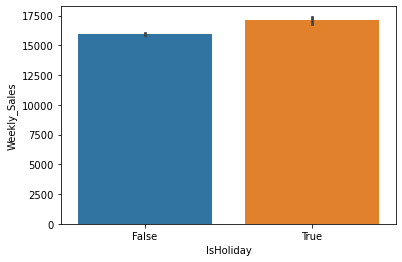

In [17]:
#Let's look at the Holidays baby
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [18]:
#What are the dates
holiday = df.loc[df['IsHoliday']==True]
holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

Looks like Walmart does most of it's sales on four weeks per year that have a holiday, guessing by the dates it looks like Superbowl, Labor Day(?), Thanksgiving, and Christmas/New Years.

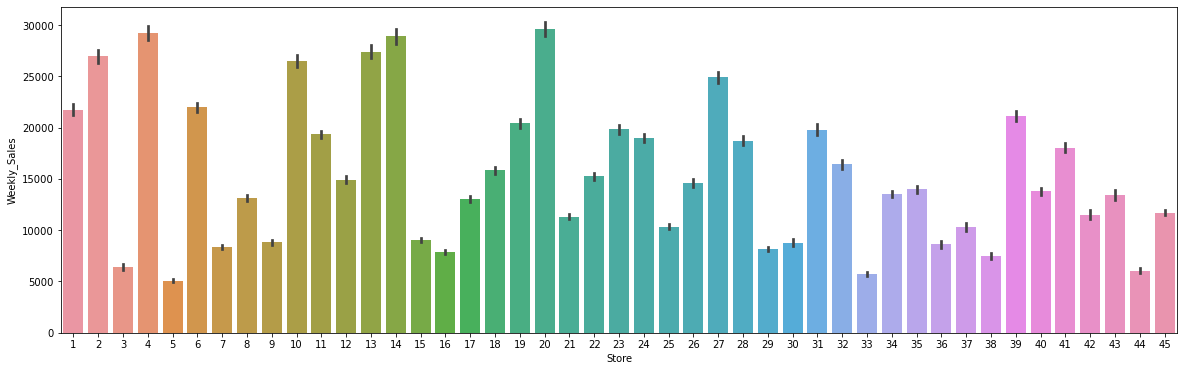

In [19]:
#Let's look at our target variable weekly sales
plt.figure(figsize=(20,6), facecolor='w')
fig = sns.barplot(data=df, x='Store', y="Weekly_Sales")

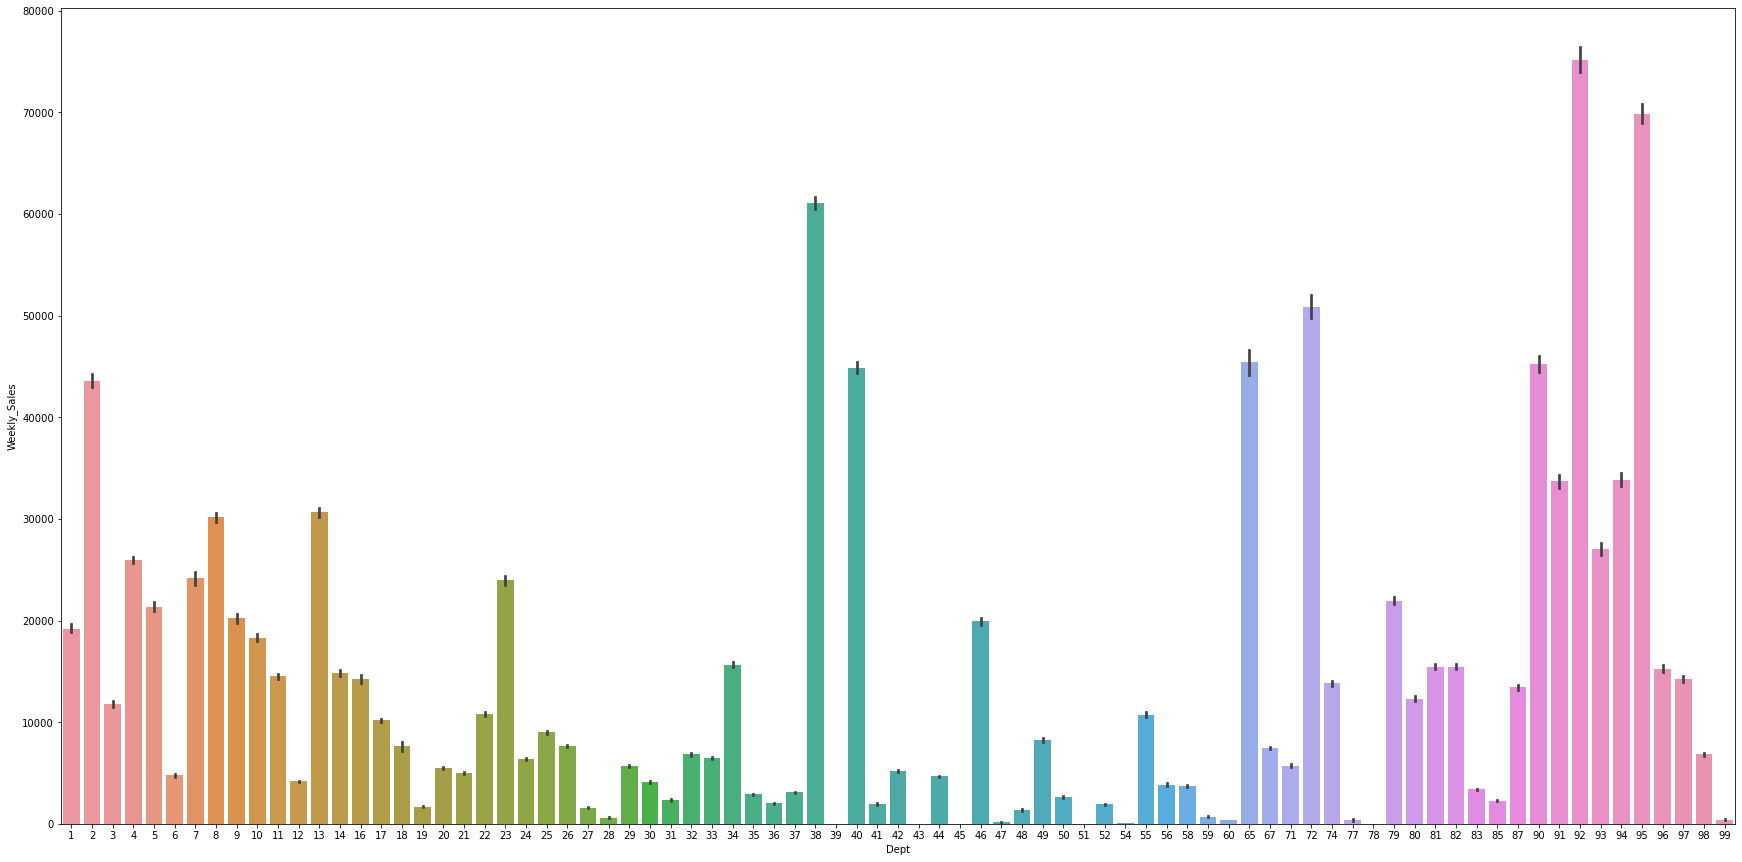

In [20]:
plt.figure(figsize=(30,15), facecolor='w')
fig = sns.barplot(data=df, x='Dept', y='Weekly_Sales')

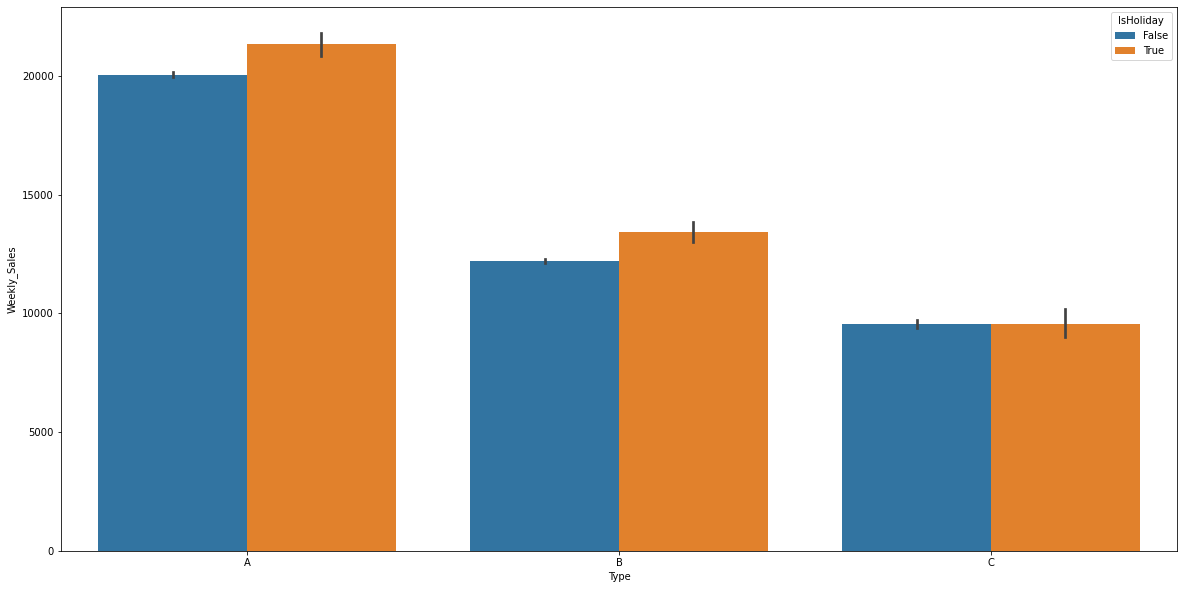

In [21]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.barplot(data=df, x=df['Type'], y = df['Weekly_Sales'], hue='IsHoliday')

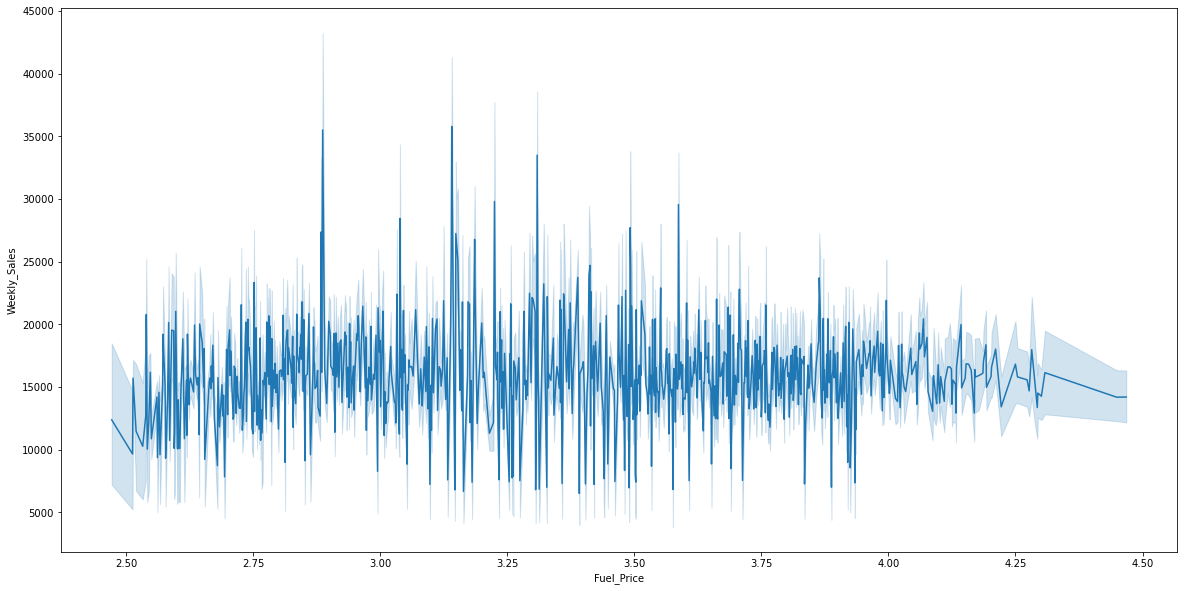

In [22]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.lineplot(data=df, x="Fuel_Price", y="Weekly_Sales")

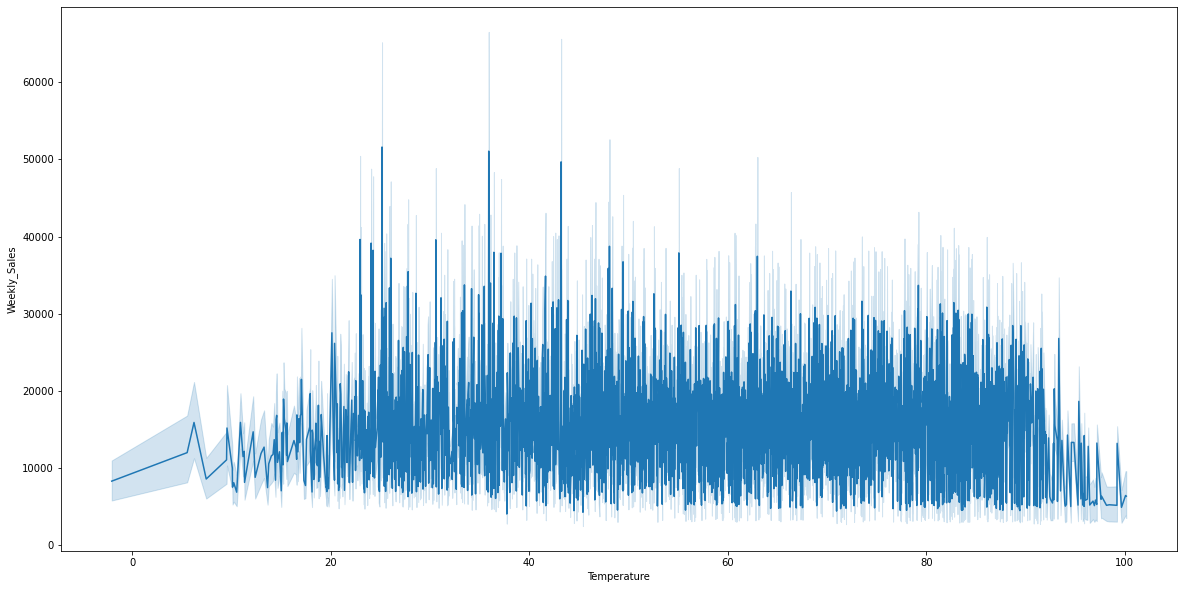

In [23]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.lineplot(data=df, x="Temperature", y="Weekly_Sales")

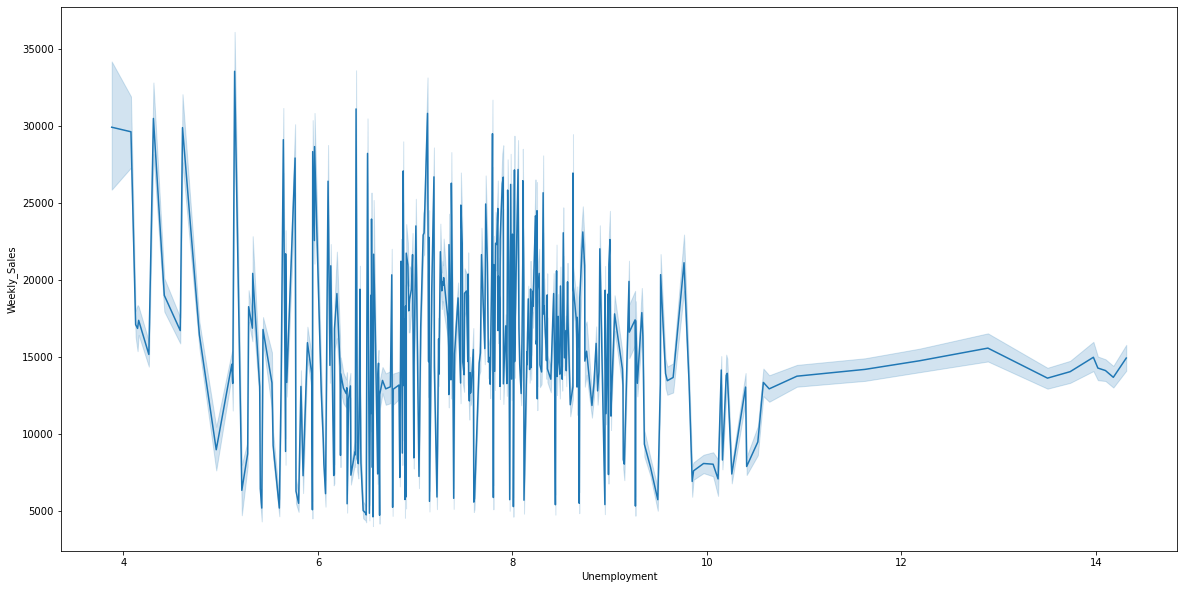

In [24]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.lineplot(data=df, x="Unemployment", y="Weekly_Sales")

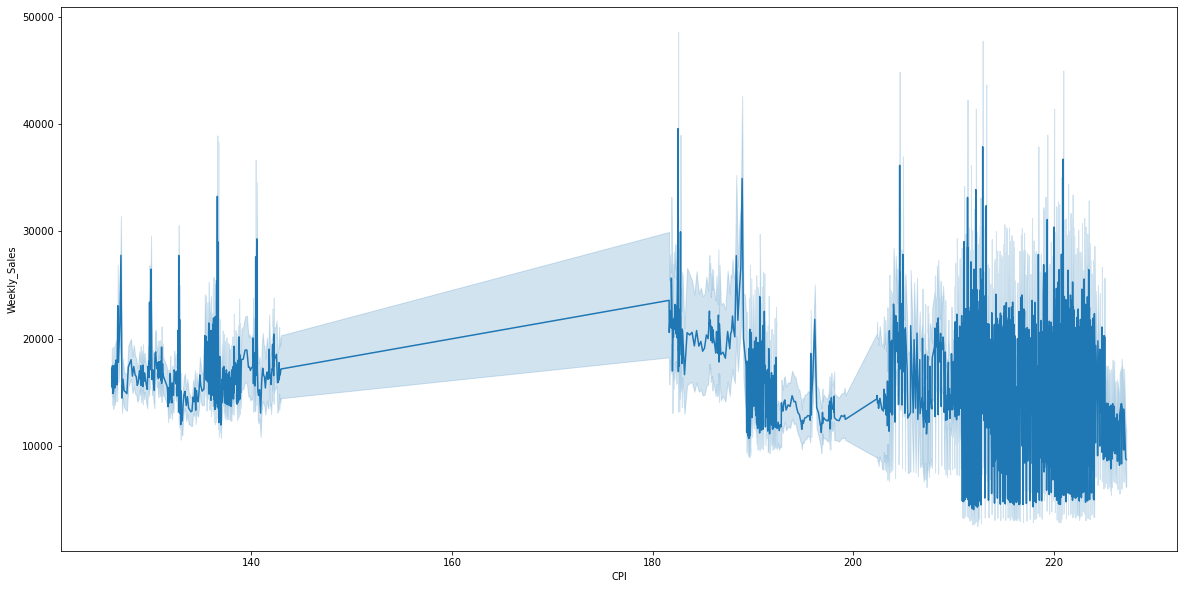

In [25]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.lineplot(data=df, x="CPI", y="Weekly_Sales")

C:\Users\evere\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


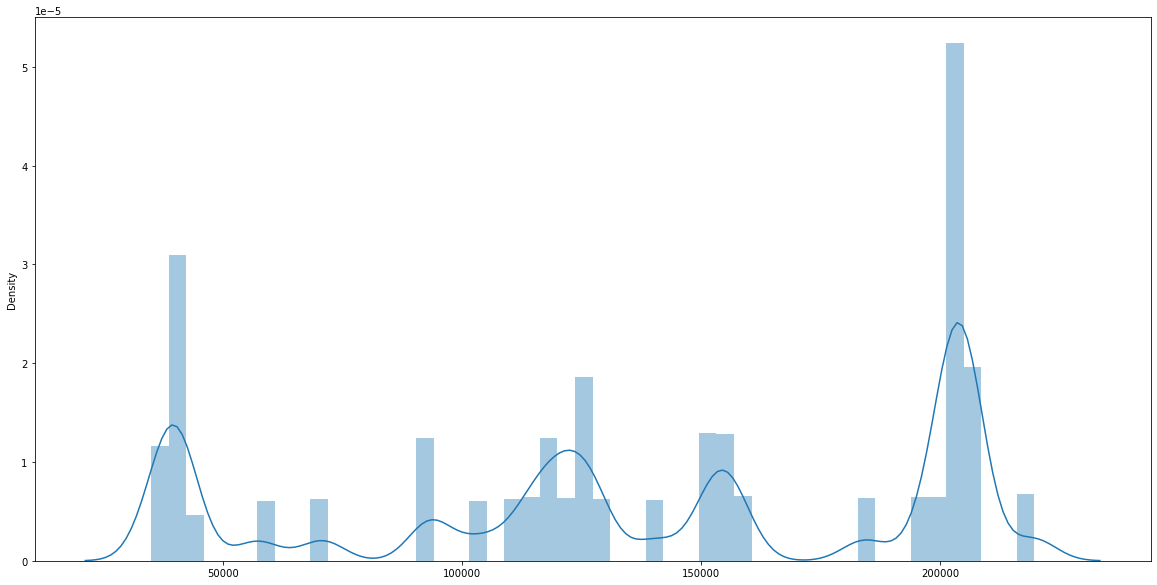

In [26]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.distplot(df, x=df['Size'])

In [27]:
#Assigns the Quartile positions of the continuous variable to it's quartile as an object
df['Cat_Size'] = pd.qcut(df['Size'],3,['small','medium','large'])

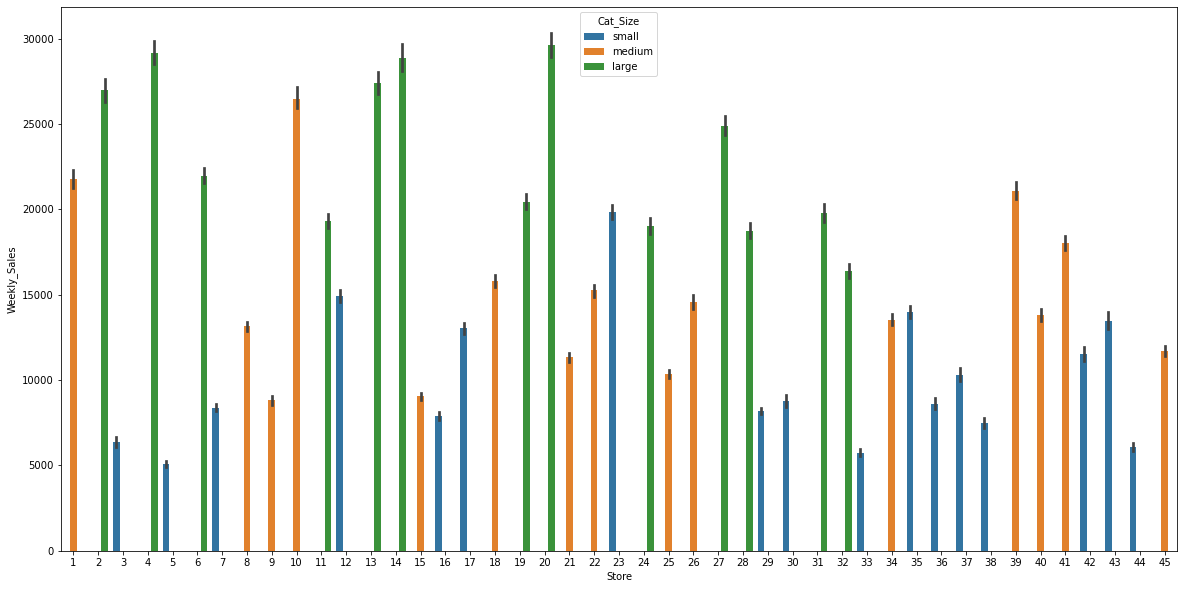

In [28]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.barplot(data=df, x='Store', y='Weekly_Sales', hue='Cat_Size')

In [29]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] = df['Date'].dt.week
df['month'] = df['Date'].dt.month 
df['year'] = df['Date'].dt.year

C:\Users\evere\AppData\Local\Temp\ipykernel_24288\1323172372.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['Date'].dt.week


In [30]:
month_sales = df.groupby('month')['Weekly_Sales'].mean()
month_sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

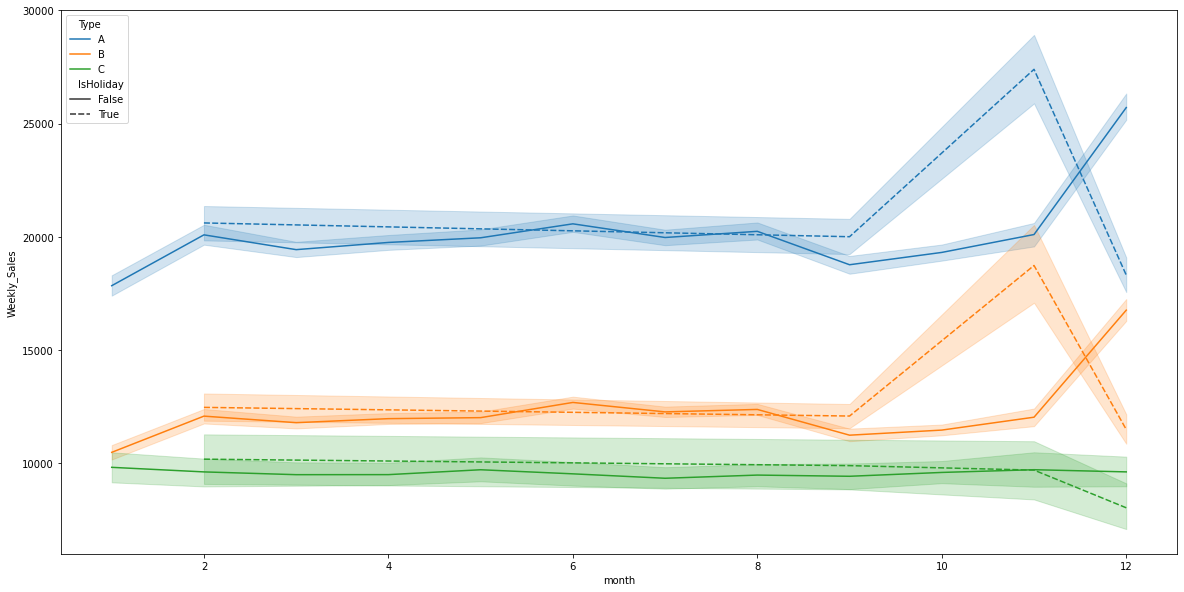

In [31]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.lineplot(data=df, x=df['month'], y=df['Weekly_Sales'], hue=df['Type'], style=df['IsHoliday'])

In [32]:
year_sales = df.groupby('year')['Weekly_Sales'].mean()
year_sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

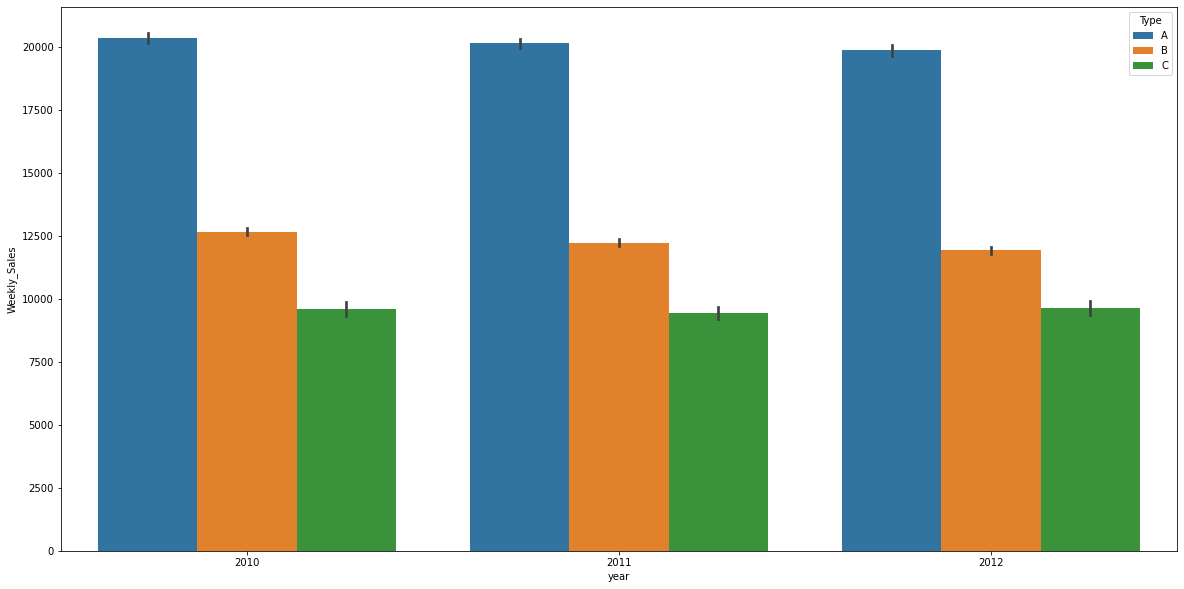

In [33]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.barplot(data=df, x=df['year'], y=df['Weekly_Sales'], hue=df['Type'])

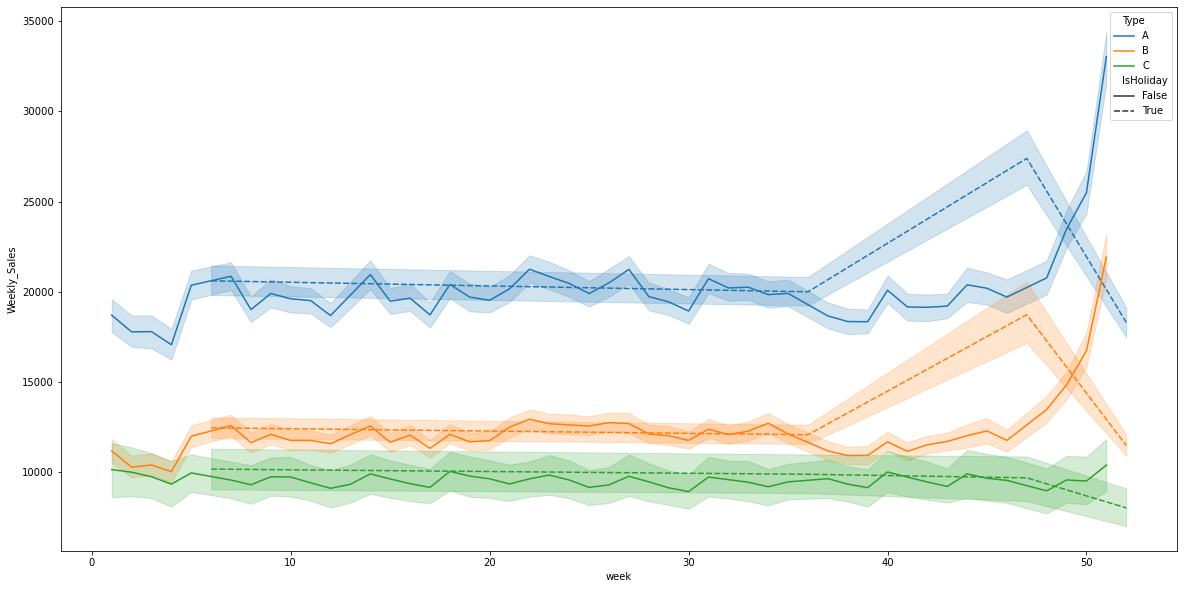

In [34]:
plt.figure(figsize=(20,10), facecolor='w')
fig = sns.lineplot(data=df, x=df['week'], y=df['Weekly_Sales'], hue=df['Type'], style=df['IsHoliday'])

In [35]:
#Encode Category Data
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
Cat_Size              category
week                     int64
month                    int64
year                     int64
dtype: object

In [36]:
df.drop('Cat_Size', axis=1, inplace=True)

labelencoder=LabelEncoder()

df['IsHoliday'] = labelencoder.fit_transform(df['IsHoliday'])
df['Type'] = labelencoder.fit_transform(df['Type'])

df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,5,2,2010
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,5,2,2010
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,5,2,2010


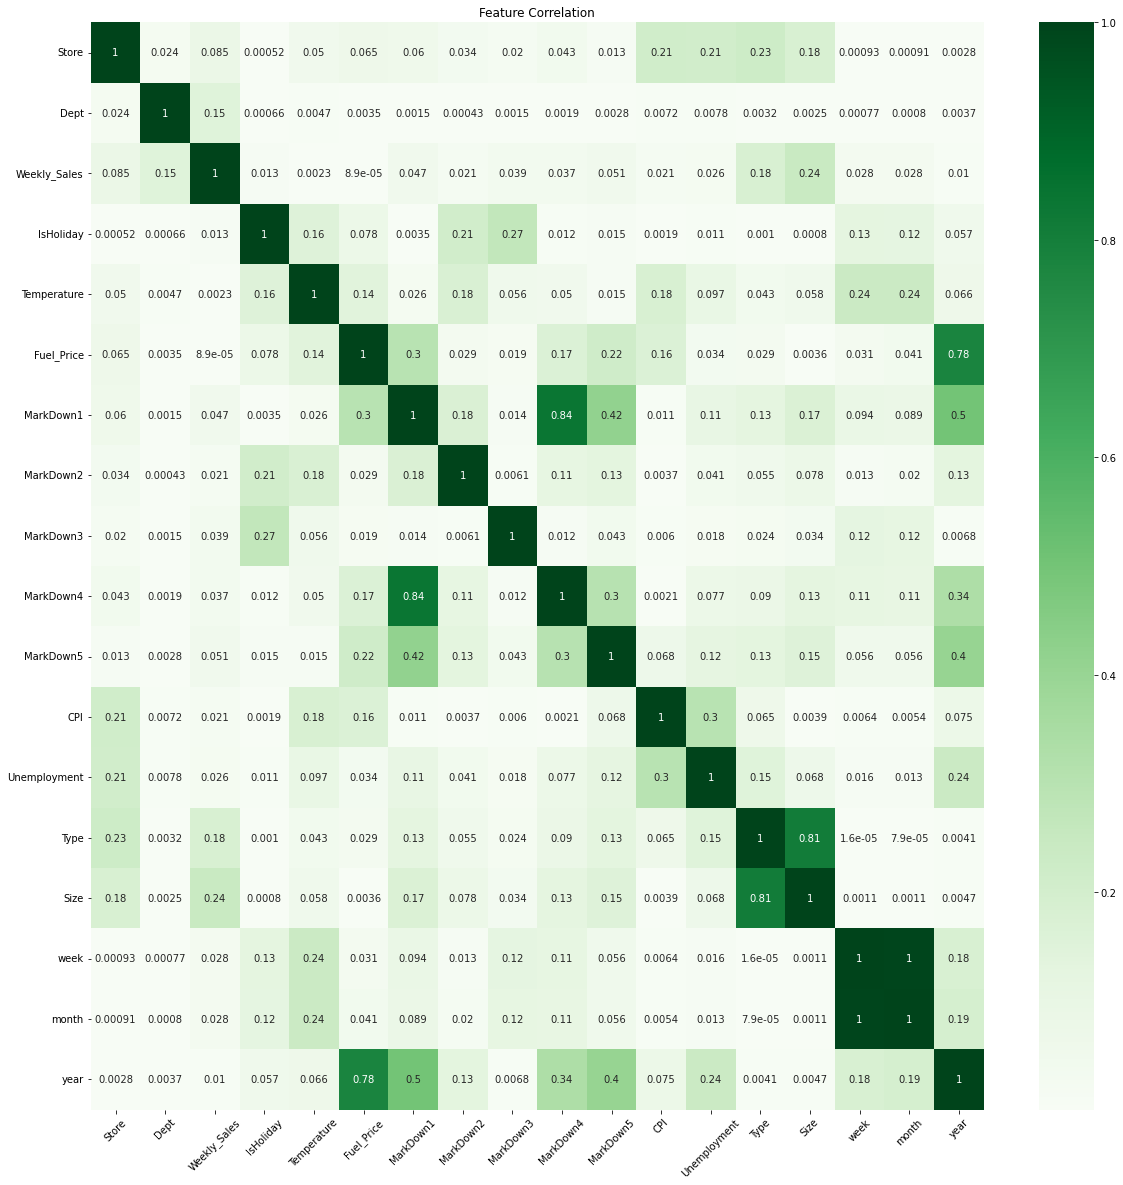

In [37]:
corr = df.corr()
plt.figure(figsize=(20,20), facecolor='w')
sns.heatmap(corr.abs(), cmap='Greens', annot=True)
plt.title('Feature Correlation')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

In [38]:
#Type, Size, and Department are most correlated with Weekly Sales
#Markdown 4 is 0.84 and was initially missing 68% of values when we started, so I'm gonna drop it

df.drop('MarkDown4', axis=1, inplace=True)
df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,5,2,2010
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,5,2,2010
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,5,2,2010


In [39]:
df_copy = df.copy()
df_new = df_copy.sort_values(by='Date', ascending=True)

# Train Test Split

In [40]:
#Dropping Date. datetime64 is giving errors with preprocessing, but we have the information in other columns
df_new.drop('Date',inplace=True, axis=1)

In [41]:
X = df_new.drop(['Weekly_Sales'], axis=1)  
y = df_new["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [42]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)

rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)

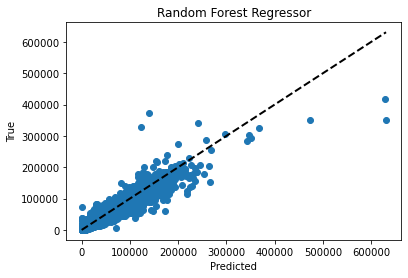

In [47]:
plt.figure(facecolor='w')
plt.scatter(y_test, y_pred_rfr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Regressor")
plt.show()

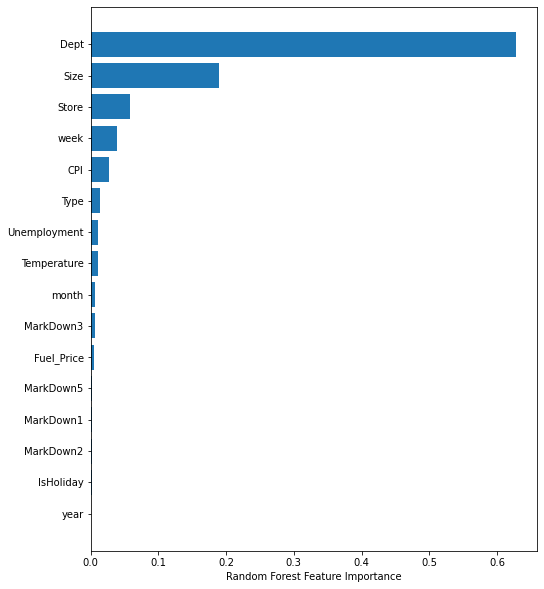

In [51]:
rfr.feature_importances_

sorted_idx = rfr.feature_importances_.argsort()
plt.figure(figsize=(8,10), facecolor='w')
plt.barh(X.columns[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [52]:
print("Test Accuracy: {}%".format(round(rfr.score(X_test, y_test)*100, 2)))
print("Model\t\t\t\t RMSE \t\t MSE \t\t MAE \t\t R2")
print("""Random Forest Regressor \t {:.2f} \t\t {:.2f} \t\t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_rfr)),mean_squared_error(y_test, y_pred_rfr),
            mean_absolute_error(y_test, y_pred_rfr), r2_score(y_test, y_pred_rfr)))

Test Accuracy: 97.33%
Model				 RMSE 		 MSE 		 MAE 		 R2
Random Forest Regressor 	 3698.77 		 13680887.62 		1456.46 		0.97


In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':np.arange(1,50)}
rfr = RandomForestRegressor()
rfr_cv = GridSearchCV(rfr, param_grid, cv=2)
rfr_cv.fit(X,y)

y_pred_rfr_cv = rfr_cv.predict(X_test)

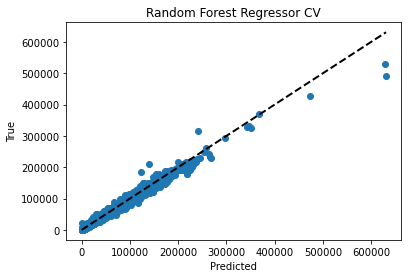

In [48]:
plt.figure(facecolor='w')
plt.scatter(y_test, y_pred_rfr_cv)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Regressor CV")
plt.show()

In [53]:
print("Test Accuracy: {}%".format(round(rfr_cv.score(X_test, y_test)*100, 2)))
print("Model\t\t\t\t RMSE \t\t MSE \t\t MAE \t\t R2")
print("""Random Forest Regressor \t {:.2f} \t\t {:.2f} \t\t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_rfr_cv)),mean_squared_error(y_test, y_pred_rfr_cv),
            mean_absolute_error(y_test, y_pred_rfr_cv), r2_score(y_test, y_pred_rfr_cv)))

Test Accuracy: 99.64%
Model				 RMSE 		 MSE 		 MAE 		 R2
Random Forest Regressor 	 1364.67 		 1862334.34 		519.02 		1.00


Make improvements

In [ ]:
!pip install xgboost

In [54]:
from xgboost import XGBRegressor

xgbr = XGBRegressor()

xgbr.fit(X_train, y_train)

y_pred_xgbr = xgbr.predict(X_test)

In [55]:
print("Test Accuracy: {}%".format(round(xgbr.score(X_test, y_test)*100, 2)))
print("Model\t\t\t\t RMSE \t\t MSE \t\t MAE \t\t R2")
print("""X Gradiant Boosting Regressor \t {:.2f} \t\t {:.2f} \t\t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_xgbr)),mean_squared_error(y_test, y_pred_xgbr),
            mean_absolute_error(y_test, y_pred_xgbr), r2_score(y_test, y_pred_xgbr)))

Test Accuracy: 94.23%
Model				 RMSE 		 MSE 		 MAE 		 R2
X Gradiant Boosting Regressor 	 5434.55 		 29534338.76 		3006.72 		0.94


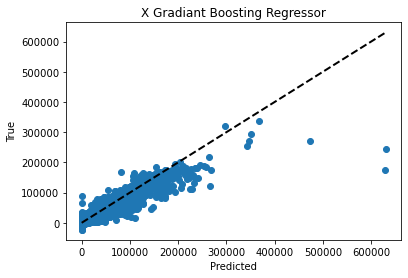

In [56]:
plt.figure(facecolor='w')
plt.scatter(y_test, y_pred_xgbr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("X Gradiant Boosting Regressor")
plt.show()